# **AvStats - Flight Delay Forecast**

*Iraia Torres, October 2024*

This project aims to develop a forecasting model for commercial flight delays. The objective is to analyze historical flight data and investigate how delays are influenced by factors such as flight routes, weather conditions, and passenger volumes. The expected outcome is to generate daily or weekly predictions of flight delays.

The project includes two main Jupyter notebooks that go through data preparation, EDA, and model development.

### **Notebook 2 - Predictive Models**
**Note**: *Run the EDA pipeline or notebook before*

This notebook includes feature engineering, ML model training, and performance evaluation.

1. Machine Learning Regression Models
    * Linear Regression
    
    * Decision Tree
      
    * Random Forest
    
    * Support Vector Regression (SVR)
      
    * Gradient Boosting Machines (GBM)
      
    * XGBoost
    
    * Neural Networks
    
2. Statistical Time-Series Models
    * ARIMA. Determine d (I), p & q (AR and MA)
    
    * SARIMAX
    
    * Rolling Forecast Origin
    
    * Prophet 
    
3. Evaluation Methods
    * Data Validation (Cross-Validation)
    
    * Learning Curve Pipeline
    
    * Prediction Accuracy

    * Residual Analysis

    * Comparison of Methods

In [1]:
import os
from datetime import datetime
from core.ML.TimeSeriesAnalysis import TimeSeriesAnalysis
from core.ML.NeuralNetworks import nn_plots, NeuralNetworks
from core.ML.ModelPipeline import ModelPipeline
from core.ML.ModelEvaluation import *
# from core.ML.ResidualAnalysis import ResidualAnalysis

##### **Explanation of Different Dataframes**

Meaning of the different dataframes used through the modelling and predictions.
* **df_original**. Original 2023 flight schedule dataset with cleaned data and new features | **340k rows**; one for each flight | **ML Models**
* **df_weather_daily**. Flights are grouped daily per route | **75k rows**; one for each day per route | **Neural Networks**
* **df_passengers_vif**. Same as *df_passengers_monthly* after feature selection | **756 rows**; one per month per route | **ML Models**
* **df_BRU_MAD**. Same as *df_weather_encoded* but with just 1 route | **364 rows**; one per day | **ARIMA/SARIMAX/Rolling Forecast**

In [2]:
# Load the DataFrames for ML
df_vif_original = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_vif_original.csv"))
df_vif_weather = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_vif_weather.csv"))
df_vif_passengers = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_vif_passengers.csv"))
df_vif_BRU_MAD = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_vif_BRU_MAD.csv"))

df_filtered_original = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_filtered_original.csv"))
df_filtered_weather = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_filtered_weather.csv"))
df_filtered_passengers = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_filtered_passengers.csv"))
df_filtered_BRU_MAD = pd.read_csv(os.path.join("..", r"data\data_for_machine_learning", "df_filtered_BRU_MAD.csv"))

# Load the DataFrames for NN
#df_scaled_original = pd.read_csv(os.path.join("..", r"data\data_for_nn", "df_scaled_original.csv"))
#df_scaled_weather = pd.read_csv(os.path.join("..", r"data\data_for_nn", "df_scaled_weather.csv"))
#df_scaled_BRU_MAD = pd.read_csv(os.path.join("..", r"data\data_for_nn", "df_scaled_BRU_MAD.csv"))
#df_scaled_passengers = pd.read_csv(os.path.join("..", r"data\data_for_nn", "df_scaled_passengers.csv"))

# Load the DataFrames for Time-Series
df_BRU_MAD_daily = pd.read_csv(os.path.join("..", r"data\data_for_time_series", "df_BRU_MAD_daily.csv"))

print("DataFrames loaded successfully")

DataFrames loaded successfully


### **1. Machine Learning Models**

- If predicting flight delays based only on past delays → Prophet or SARIMAX
- If including weather, passengers, and route details → Machine Learning (XGBoost, GBM)
- For best accuracy → Combine time-series forecasting + ML models

**Linear Regression**

First, linear regression will be used since it provides a **quick initial understanding** of the relationship between the predictors (independent) and the target variable (dependent). It's useful to detect **multicollinearity** (correlation between features) and to see if a **simple model** is enough to get good results before moving to complex ones.


In [3]:
# Define data
original_data = [(df_filtered_original, 'dep_delay')]
weather_data = [(df_filtered_weather, 'total_dep_delay')]
passenger_data = [(df_filtered_passengers, 'total_dep_delay')]
BRU_MAD_data = [(df_filtered_BRU_MAD, 'total_dep_delay')]

# Define hyperparameter grids
param_grids = {
    "Decision Tree": {"max_depth": [3, 5, 10], "min_samples_split": [5, 10, 20]},
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [5, 10, None]}, 
    "SVR": {"C": [0.1, 1, 10, 100], "gamma": ["scale", "auto", 0.01, 0.1, 1]},
    "Gradient Boosting": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.05, 0.1]},
    "XGBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1], "max_depth": [3, 5, 7]},
}
models_to_train = ["Linear Regression", "Decision Tree", "Random Forest", "SVR", "Gradient Boosting", "XGBoost"]

#### **1.1. Original Dataset**

,Dataset,Model,Best Params,MAE (min.),MAPE (%),RMSE (min.),Mean CV R2,Std CV R2,CV Scores
0,Original Data,Linear Regression,Default,9.71,75.61,12.28,0.324616,0.003775,"[0.3256816994199817, 0.330723548260644, 0.3189..."
1,Original Data,Decision Tree,"{'max_depth': 10, 'min_samples_split': 20}",9.44,72.93,12.07,0.324616,0.003775,"[0.3256816994199817, 0.330723548260644, 0.3189..."


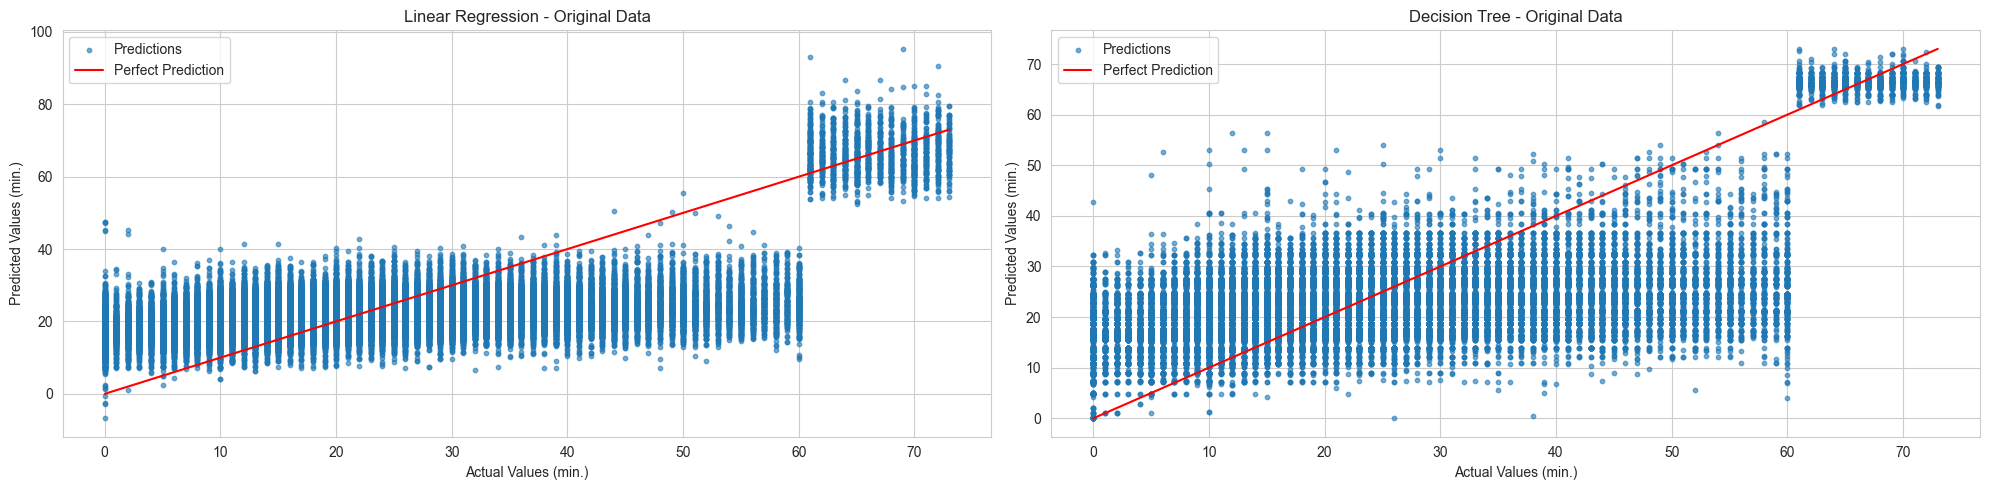

In [5]:
# Initialize the model pipeline
pipeline_original = ModelPipeline(dataframes=original_data, titles=["Original Data"], models_to_train=["Linear Regression", "Decision Tree"], param_grids=param_grids)

# Train models and get the summary DataFrame
model_summary_original_df = pipeline_original.train_models()

# Display model summaries
display(model_summary_original_df)

# Plot results (Actual vs Predicted)
pipeline_original.plot_results()

#### **1.2. Including Weather Data**

,Dataset,Model,Best Params,MAE (min.),MAPE (%),RMSE (min.),Mean CV R2,Std CV R2,CV Scores
0,Weather Data,Linear Regression,Default,71.56,28.34,99.63,0.930287,0.001834,"[0.9288840880516298, 0.9311033806648199, 0.933..."
1,Weather Data,Decision Tree,"{'max_depth': 10, 'min_samples_split': 20}",87.39,41.75,122.92,0.930287,0.001834,"[0.9288840880516298, 0.9311033806648199, 0.933..."
2,Weather Data,Gradient Boosting,"{'learning_rate': 0.1, 'n_estimators': 200}",71.24,29.94,100.96,0.930287,0.001834,"[0.9288840880516298, 0.9311033806648199, 0.933..."
3,Weather Data,XGBoost,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",70.47,28.75,100.66,0.930287,0.001834,"[0.9288840880516298, 0.9311033806648199, 0.933..."


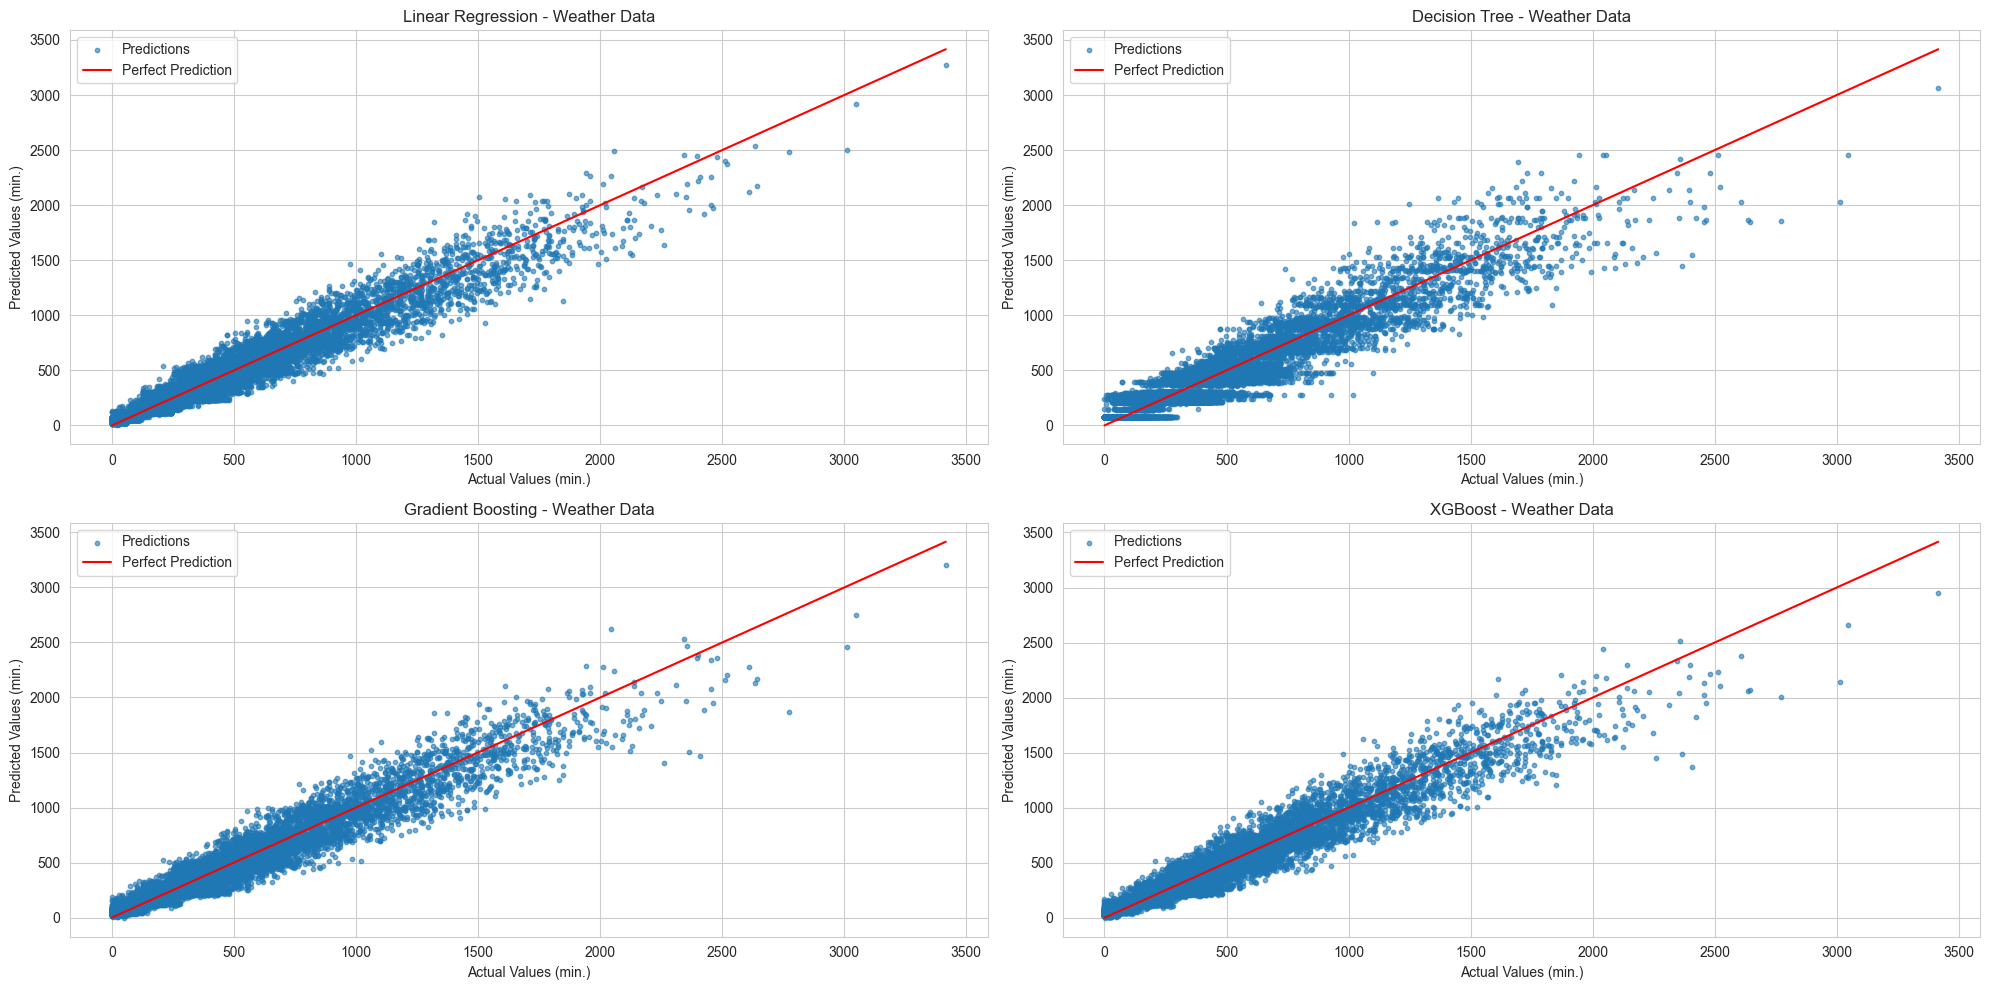

In [6]:
# Initialize the model pipeline
pipeline_weather = ModelPipeline(dataframes=weather_data, titles=["Weather Data"], models_to_train=["Linear Regression", "Decision Tree", "Gradient Boosting", "XGBoost"], param_grids=param_grids)

# Train models and get the summary DataFrame
model_summary_weather_df = pipeline_weather.train_models()

# Display model summaries
display(model_summary_weather_df)

# Plot results (Actual vs Predicted)
pipeline_weather.plot_results()

#### **1.3. Including Passenger Data**

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

,Dataset,Model,Best Params,MAE (min.),MAPE (%),RMSE (min.),Mean CV R2,Std CV R2,CV Scores
0,Passenger Data,Linear Regression,Default,1381.69,15.82,2113.00,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."
1,Passenger Data,Decision Tree,"{'max_depth': 10, 'min_samples_split': 10}",2953.37,41.72,3971.10,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."
2,Passenger Data,Random Forest,"{'max_depth': None, 'n_estimators': 200}",1972.27,21.18,2767.18,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."
3,Passenger Data,SVR,"{'C': 100, 'gamma': 0.01}",6888.70,83.63,9793.31,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."
4,Passenger Data,Gradient Boosting,"{'learning_rate': 0.1, 'n_estimators': 200}",1764.34,20.03,2464.70,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."
5,Passenger Data,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",1751.23,22.91,2391.94,0.959171,0.009422,"[0.9675798539605196, 0.9556325247874107, 0.972..."


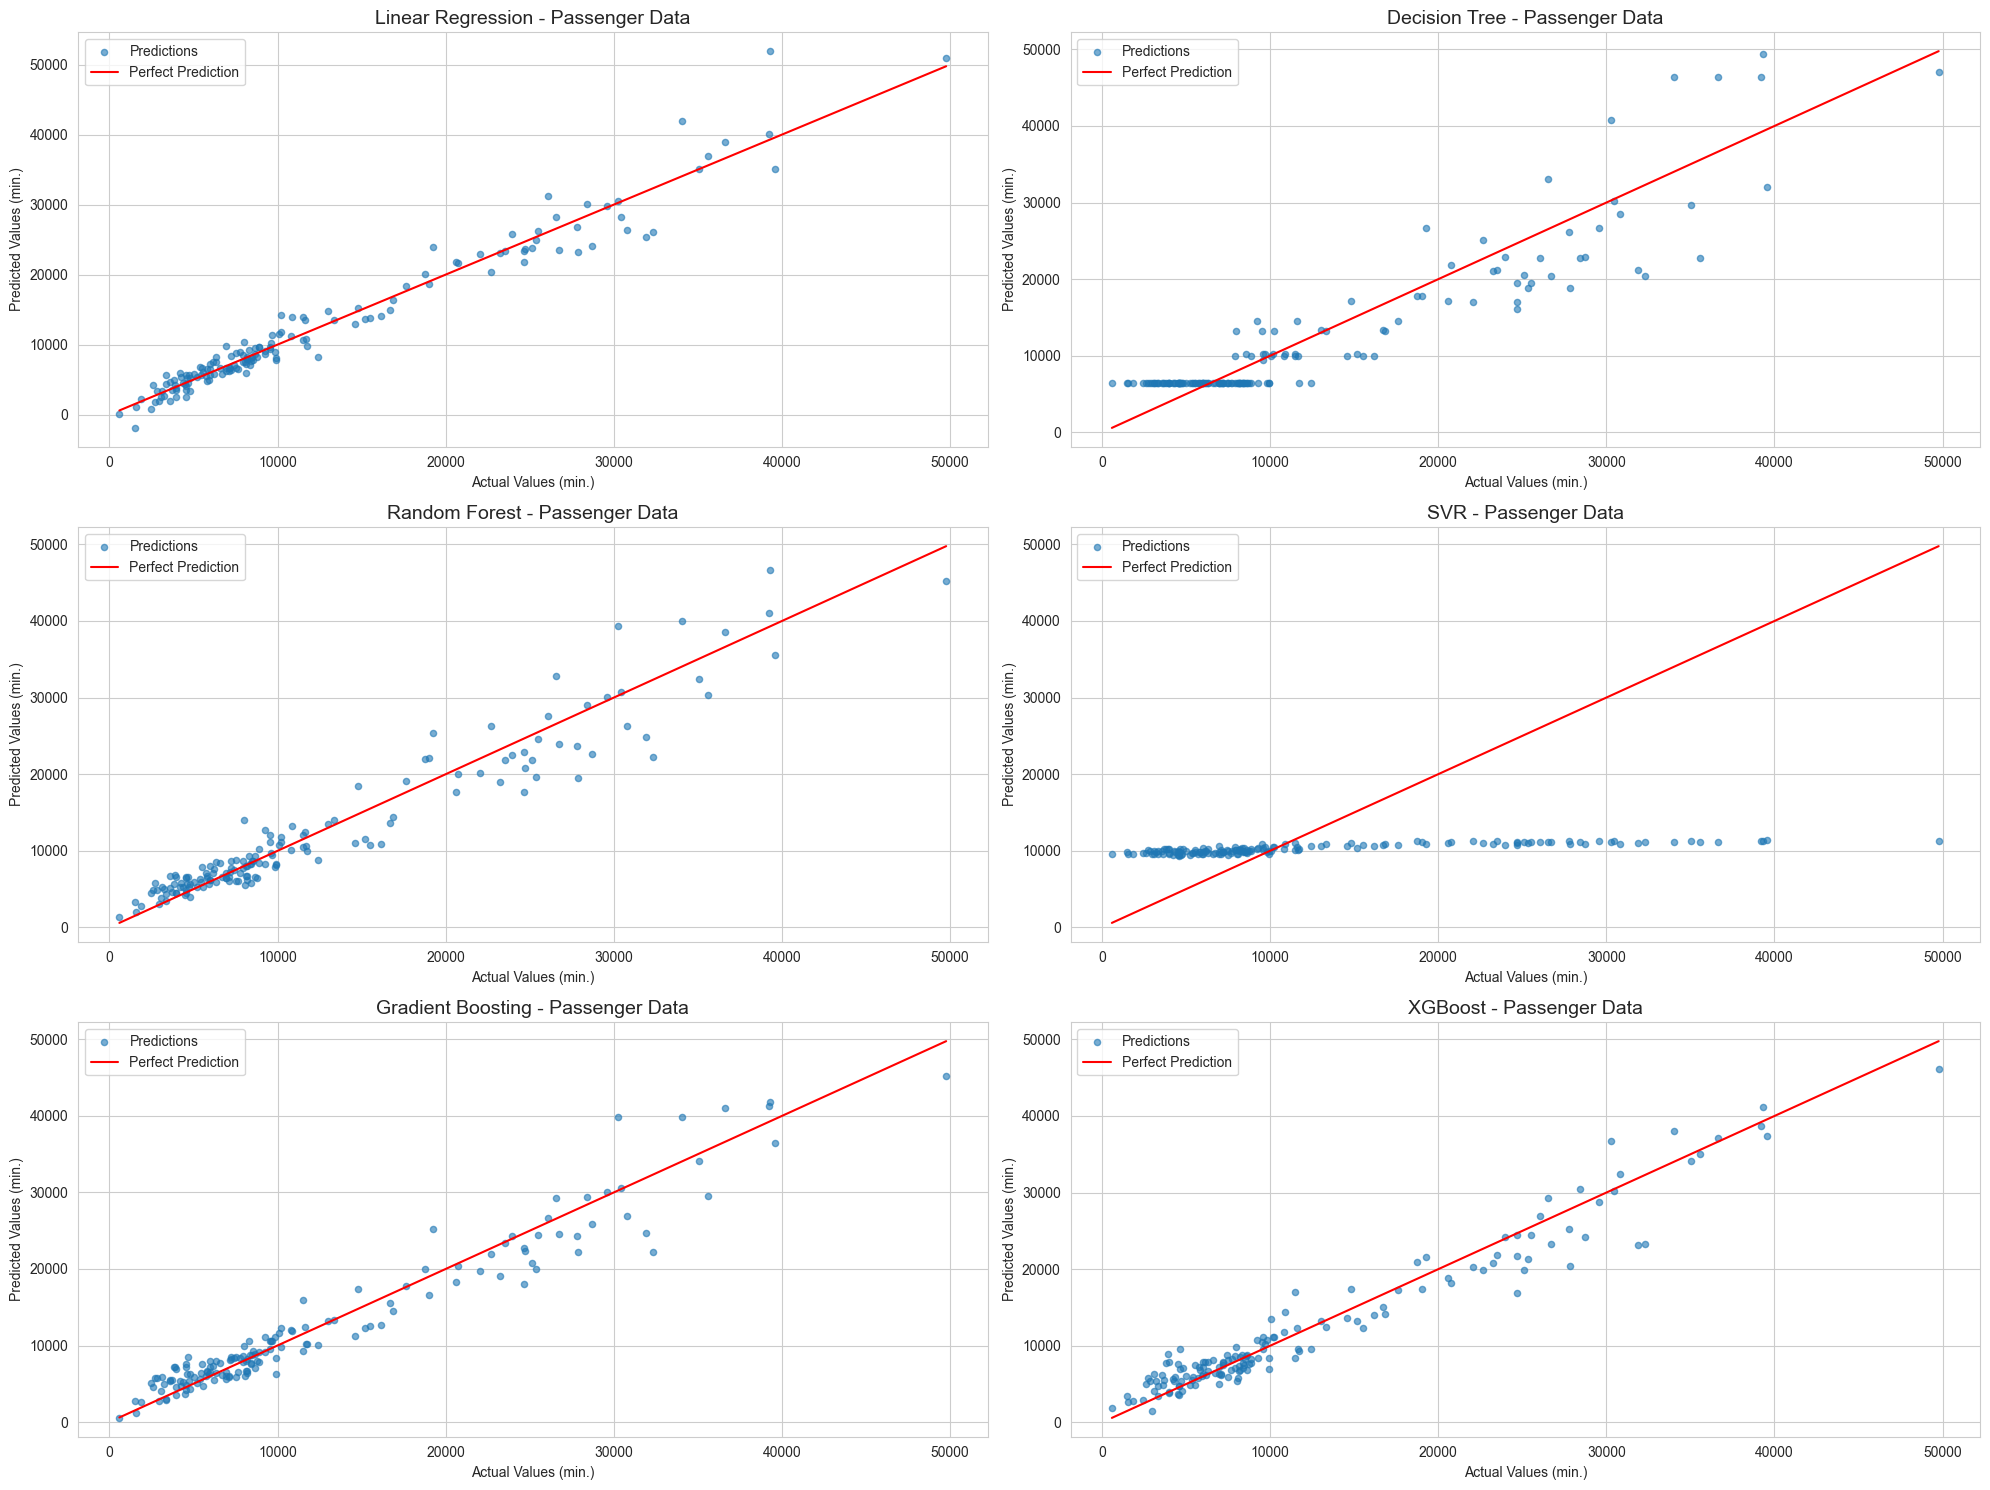

In [4]:
# Initialize the model pipeline
pipeline_passengers = ModelPipeline(dataframes=passenger_data, titles=["Passenger Data"], models_to_train=models_to_train, param_grids=param_grids)

# Train models and get the summary DataFrame
model_summary_passengers_df = pipeline_passengers.train_models()

# Display model summaries
display(model_summary_passengers_df)

# Plot results (Actual vs Predicted)
pipeline_passengers.plot_results()

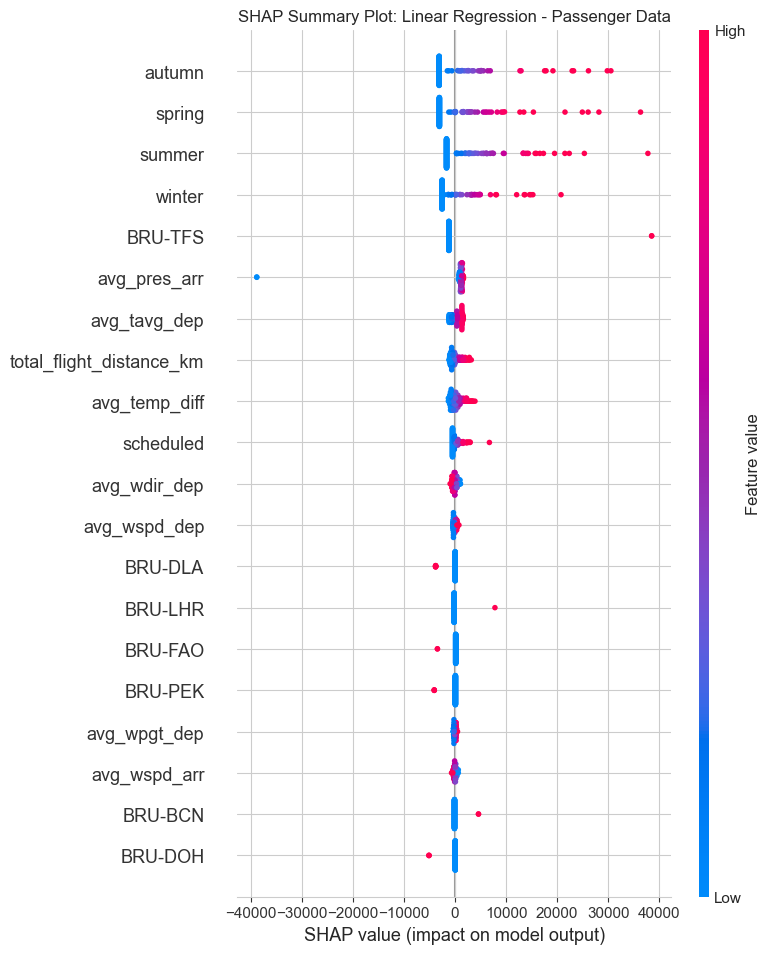

AssertionError: Feature and SHAP matrices must have the same number of rows!

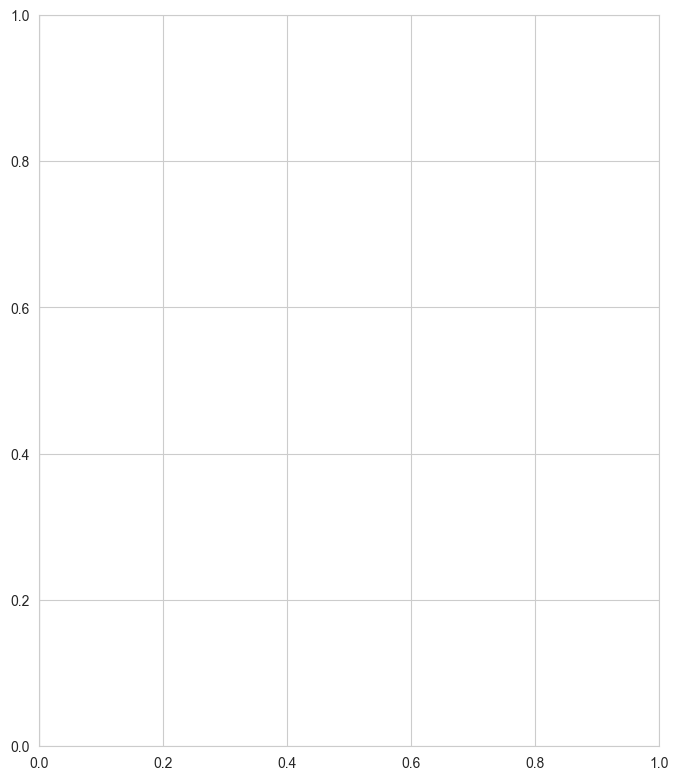

In [5]:
# Plot SHAP values
pipeline_passengers.plot_shap_values()

#### **1.4. Focusing on a single route**

,Dataset,Model,Best Params,MAE (min.),MAPE (%),RMSE (min.),Mean CV R2,Std CV R2,CV Scores
0,BRU-MAD Data,Linear Regression,Default,314.47,23.42,373.31,0.118162,0.115031,"[0.003459132642272267, 0.1490610945873223, 0.1..."
1,BRU-MAD Data,Decision Tree,"{'max_depth': 3, 'min_samples_split': 20}",342.85,25.48,403.66,0.118162,0.115031,"[0.003459132642272267, 0.1490610945873223, 0.1..."
2,BRU-MAD Data,Random Forest,"{'max_depth': 10, 'n_estimators': 200}",306.81,22.35,374.65,0.118162,0.115031,"[0.003459132642272267, 0.1490610945873223, 0.1..."
3,BRU-MAD Data,SVR,"{'C': 100, 'gamma': 0.01}",337.43,24.85,397.62,0.118162,0.115031,"[0.003459132642272267, 0.1490610945873223, 0.1..."
4,BRU-MAD Data,Gradient Boosting,"{'learning_rate': 0.01, 'n_estimators': 200}",313.00,22.90,374.66,0.118162,0.115031,"[0.003459132642272267, 0.1490610945873223, 0.1..."
5,BRU-MAD Data,XGBoost,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",325.84,24.40,383.29,0.118162,0.115031,"[0.003459132642272267, 0.1490610945873223, 0.1..."


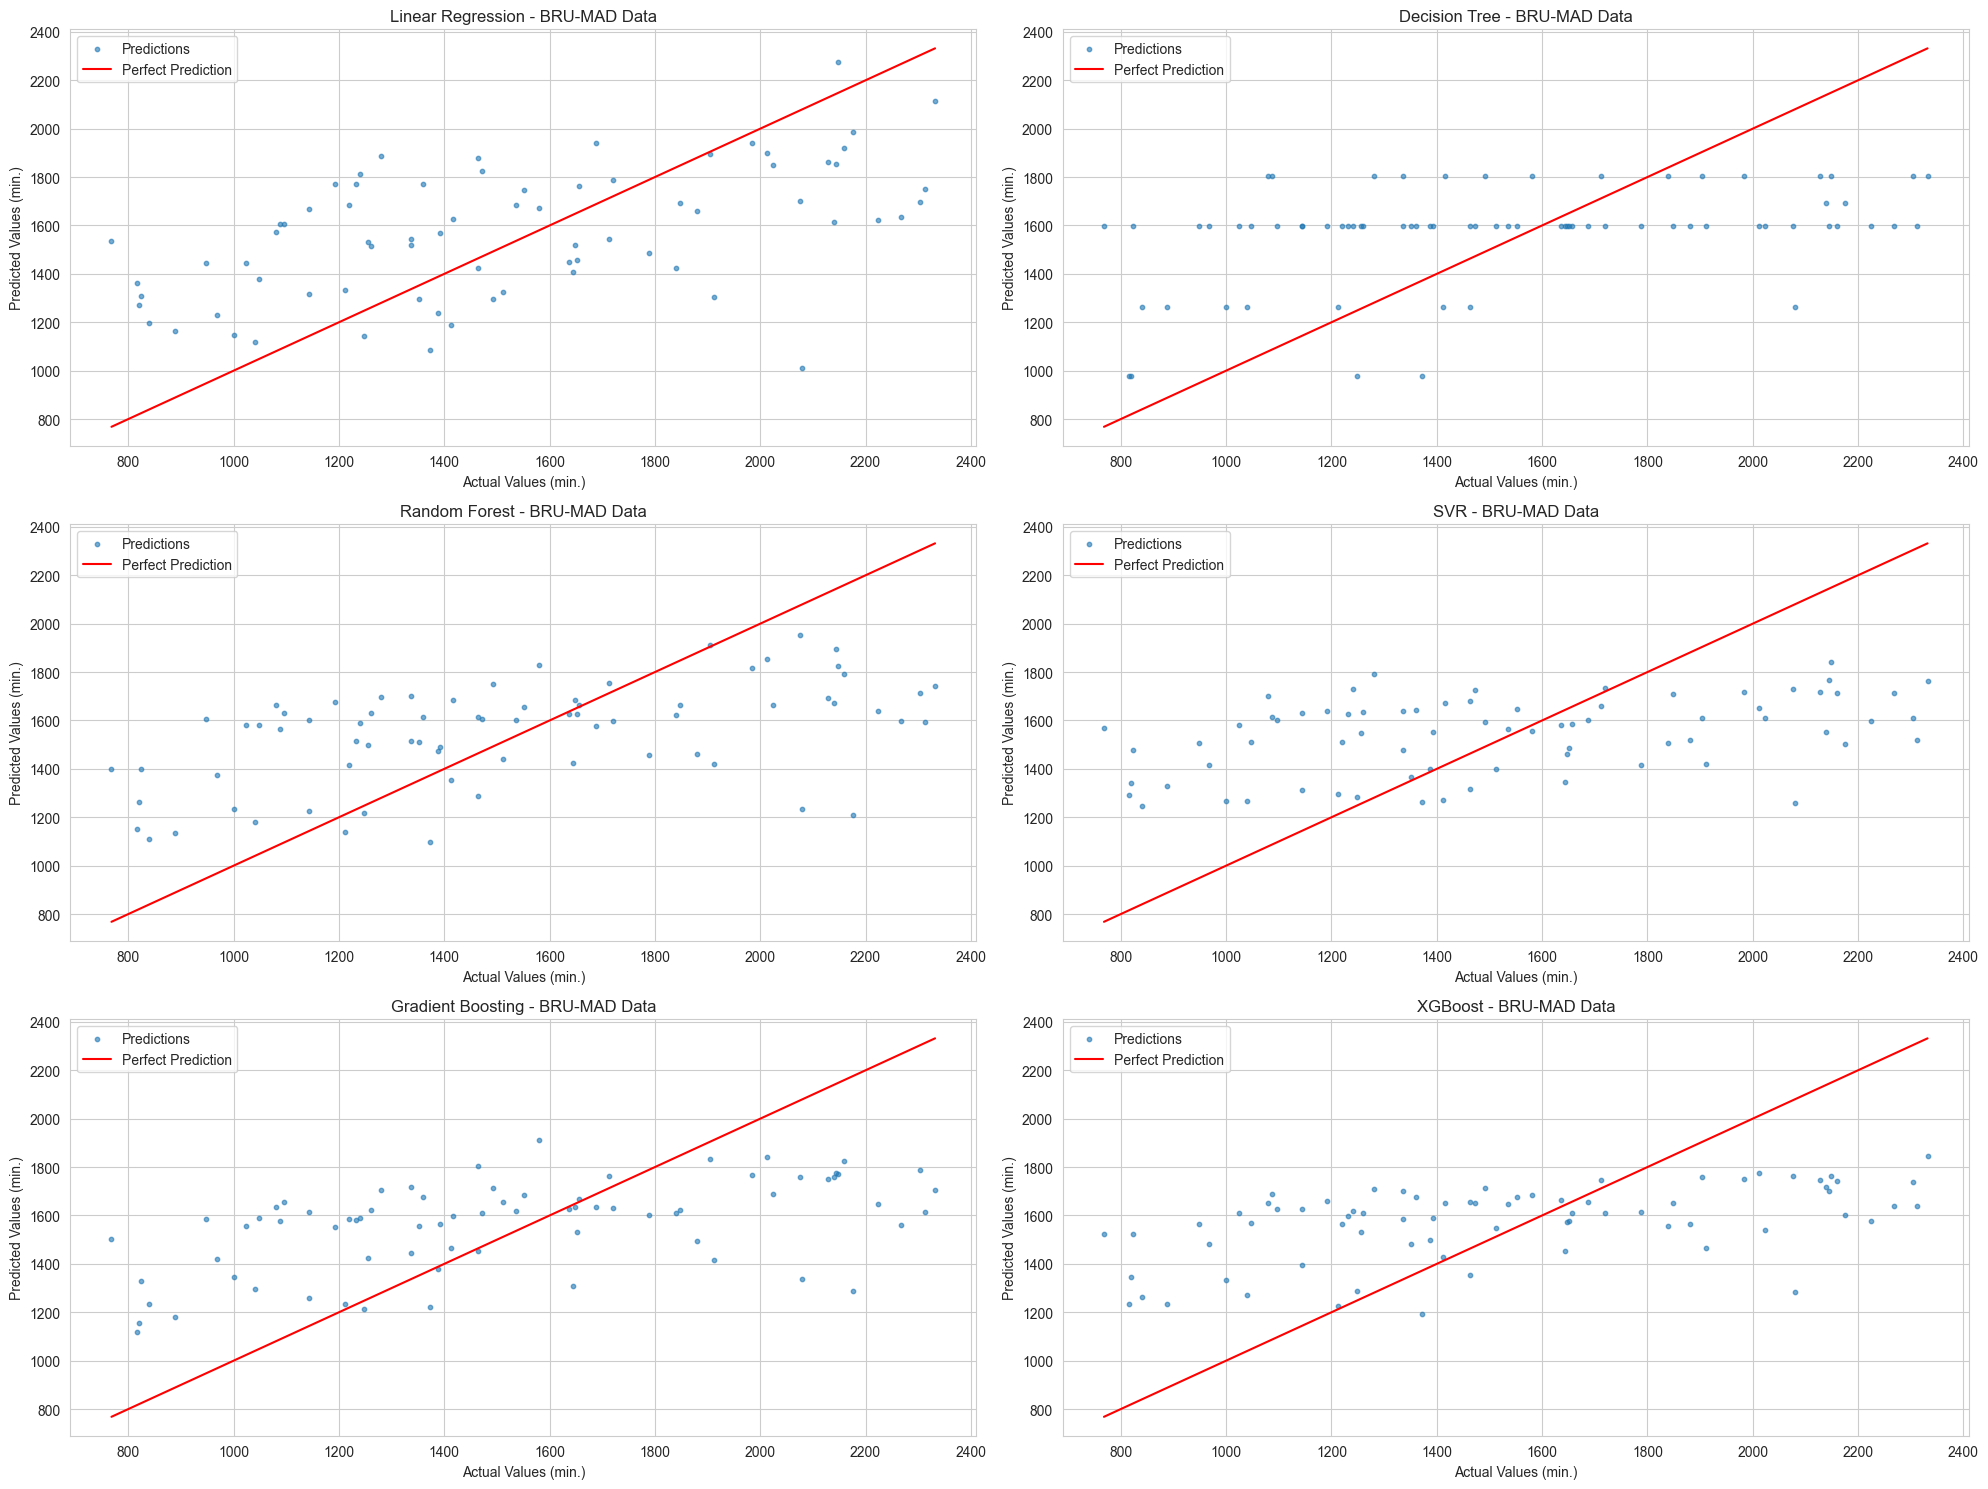

In [8]:
# Initialize the model pipeline
pipeline_BRU_MAD = ModelPipeline(dataframes=BRU_MAD_data, titles=["BRU-MAD Data"], models_to_train=models_to_train, param_grids=param_grids)

# Train models and get the summary DataFrame
model_summary_BRU_MAD_df = pipeline_BRU_MAD.train_models()

# Display model summaries
display(model_summary_BRU_MAD_df)

# Plot results (Actual vs Predicted)
pipeline_BRU_MAD.plot_results()

#### **1.5. Learning Curve Pipeline**

Hyperparameter Tuning: Helps to identify the best combination of hyperparameters that optimize model performance.

* Training Score (blue): Shows how the model performs on the training set. Usually, this error is low for large training sizes because the model fits the training data well.
* Validation Score (orange): Shows how well the model generalizes to unseen data. Ideally, this error decreases as the training size increases and stabilizes, indicating good generalization.

A good model should show:
* Decreasing validation error: The model generalizes well as it learns more data.
* Converging training & validation error: When training and validation curves are close, the model is neither underfitting nor overfitting. 



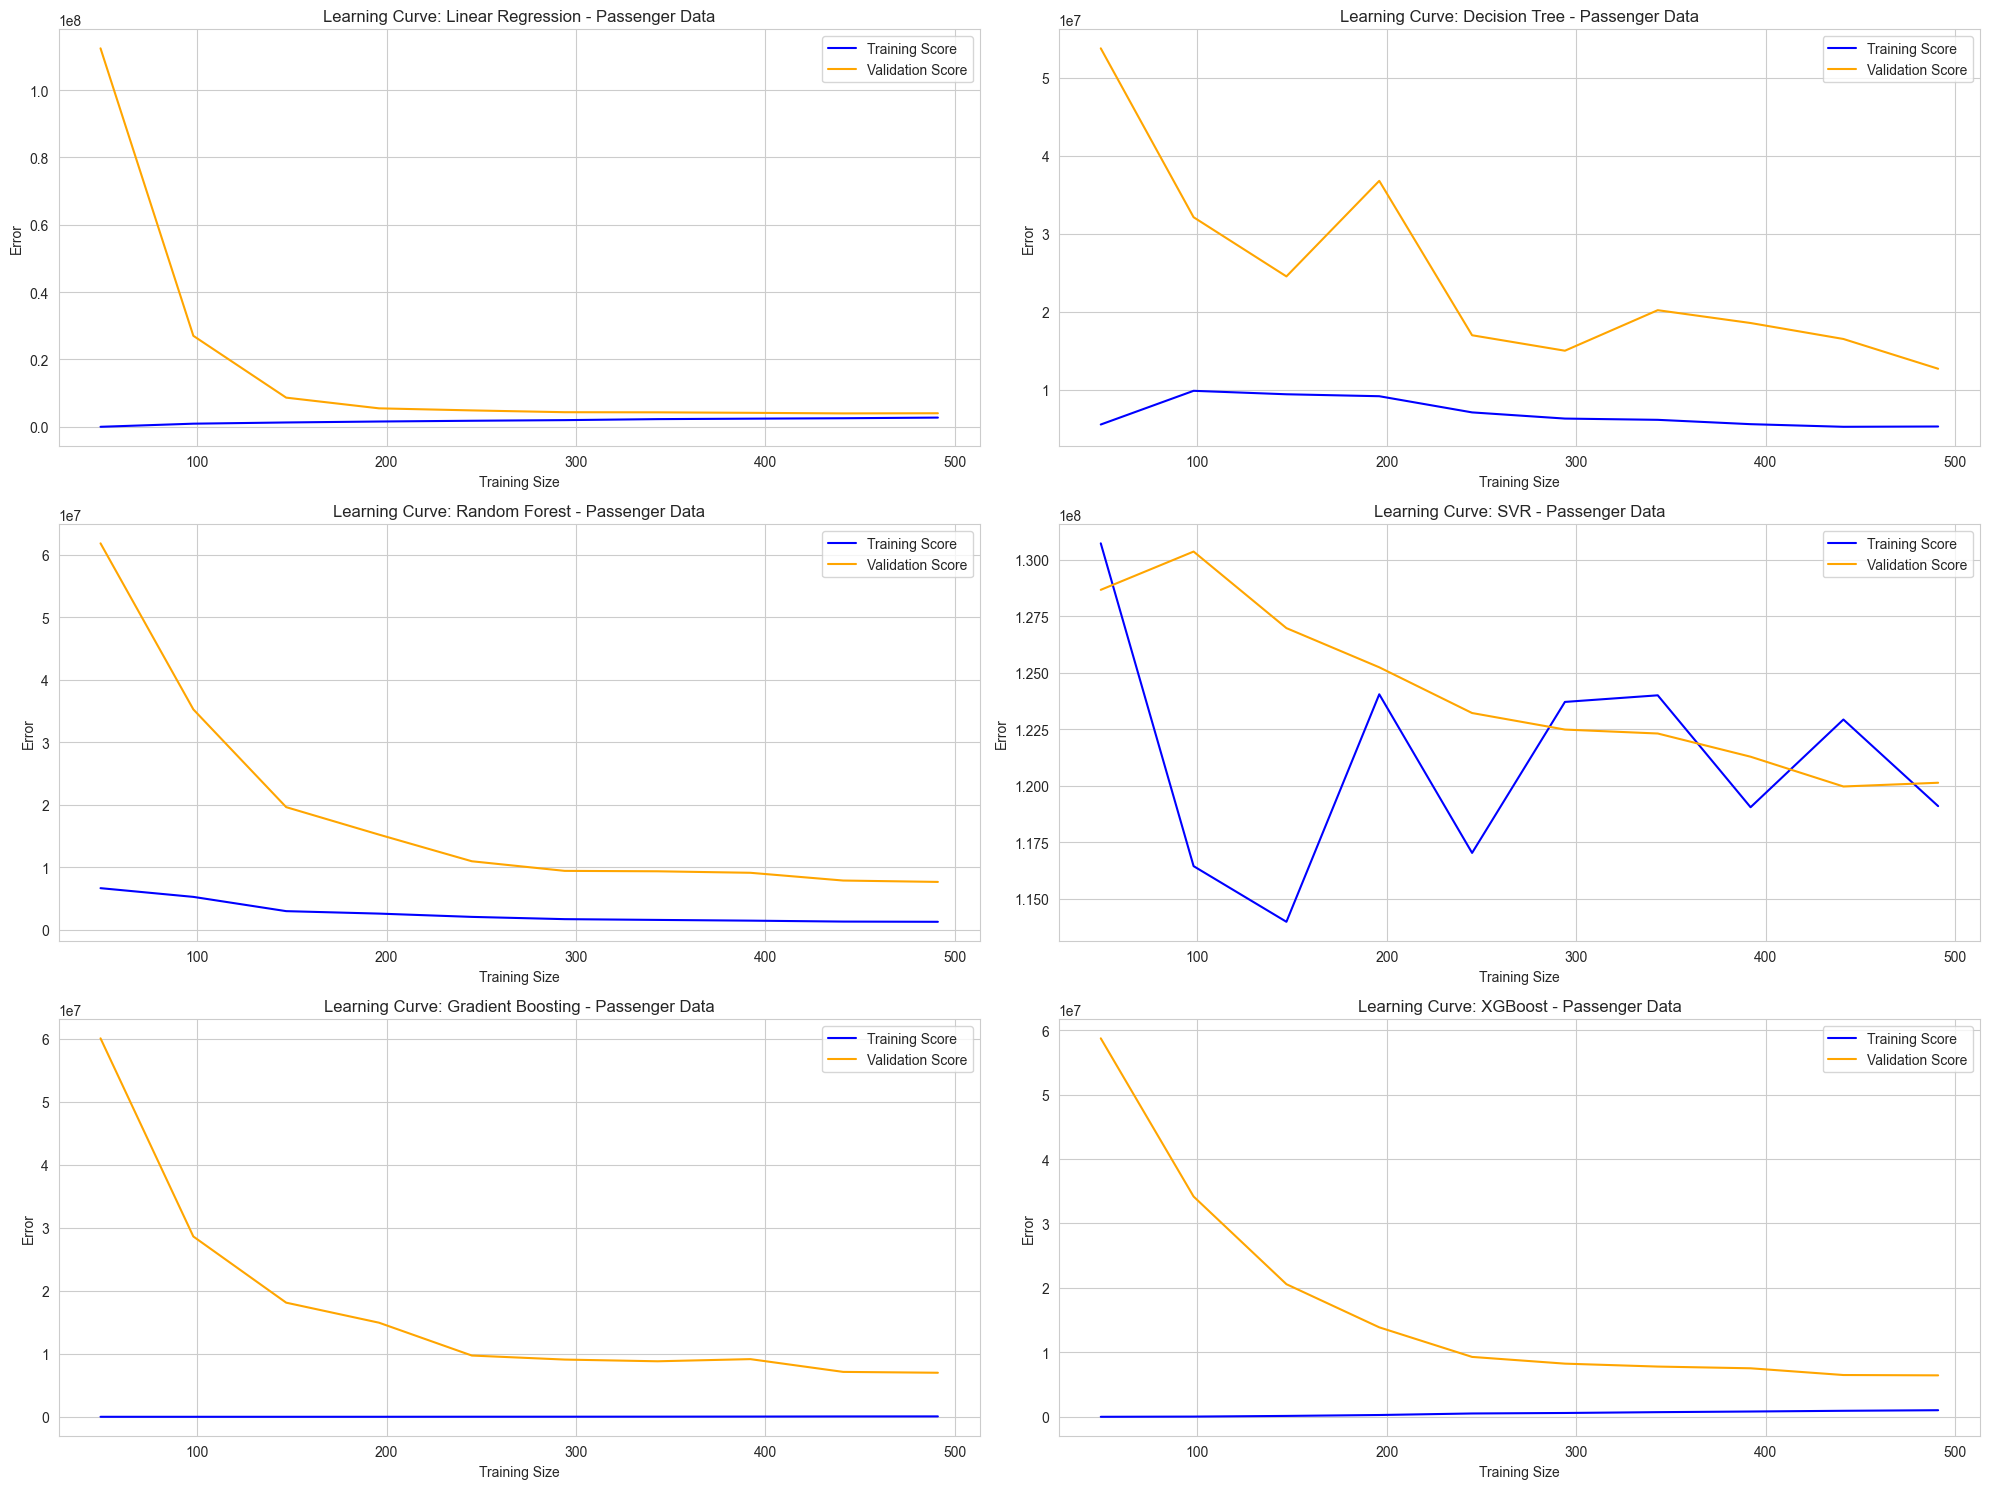

In [9]:
# Plot learning curves
pipeline_passengers.plot_learning_curves()

#### **1.6. Neural Networks**

##### **Min-Max Scaling**
**Purpose**: To scale features so that they lie within a specific range, typically [0, 1] or [-1, 1].

**How it works**: The formula for normalization is:

    Xnorm = (X − Xmin) / (Xmax - Xmin)

where:

    X is the feature value,
    Xmin is the minimum value of the feature,
    Xmax is the maximum value of the feature.

**When to use**:
* To bound features to a specific range, especially if the model is sensitive to the magnitude of the input values, like neural networks or k-NN.
* It is sensitive to outliers, as the presence of extreme values can skew the results.

Current Dataset: Original Data
Epoch 1/50
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - loss: 0.0401 - val_loss: 0.0462
Epoch 2/50
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 0.0388 - val_loss: 0.0448
Epoch 3/50
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 0.0386 - val_loss: 0.0453
Epoch 4/50
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 0.0387 - val_loss: 0.0442
Epoch 5/50
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 0.0387 - val_loss: 0.0447
Epoch 6/50
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0386 - val_loss: 0.0444
Epoch 7/50
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0387 - val_loss: 0.0447
Epoch 8/50
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 0.0387 - val_loss: 0.0443
Epoch 9/50
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.0386 - val_loss: 0.0445
2032/2032 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Current Dataset: Weather Data
Epoch 1/50
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 2

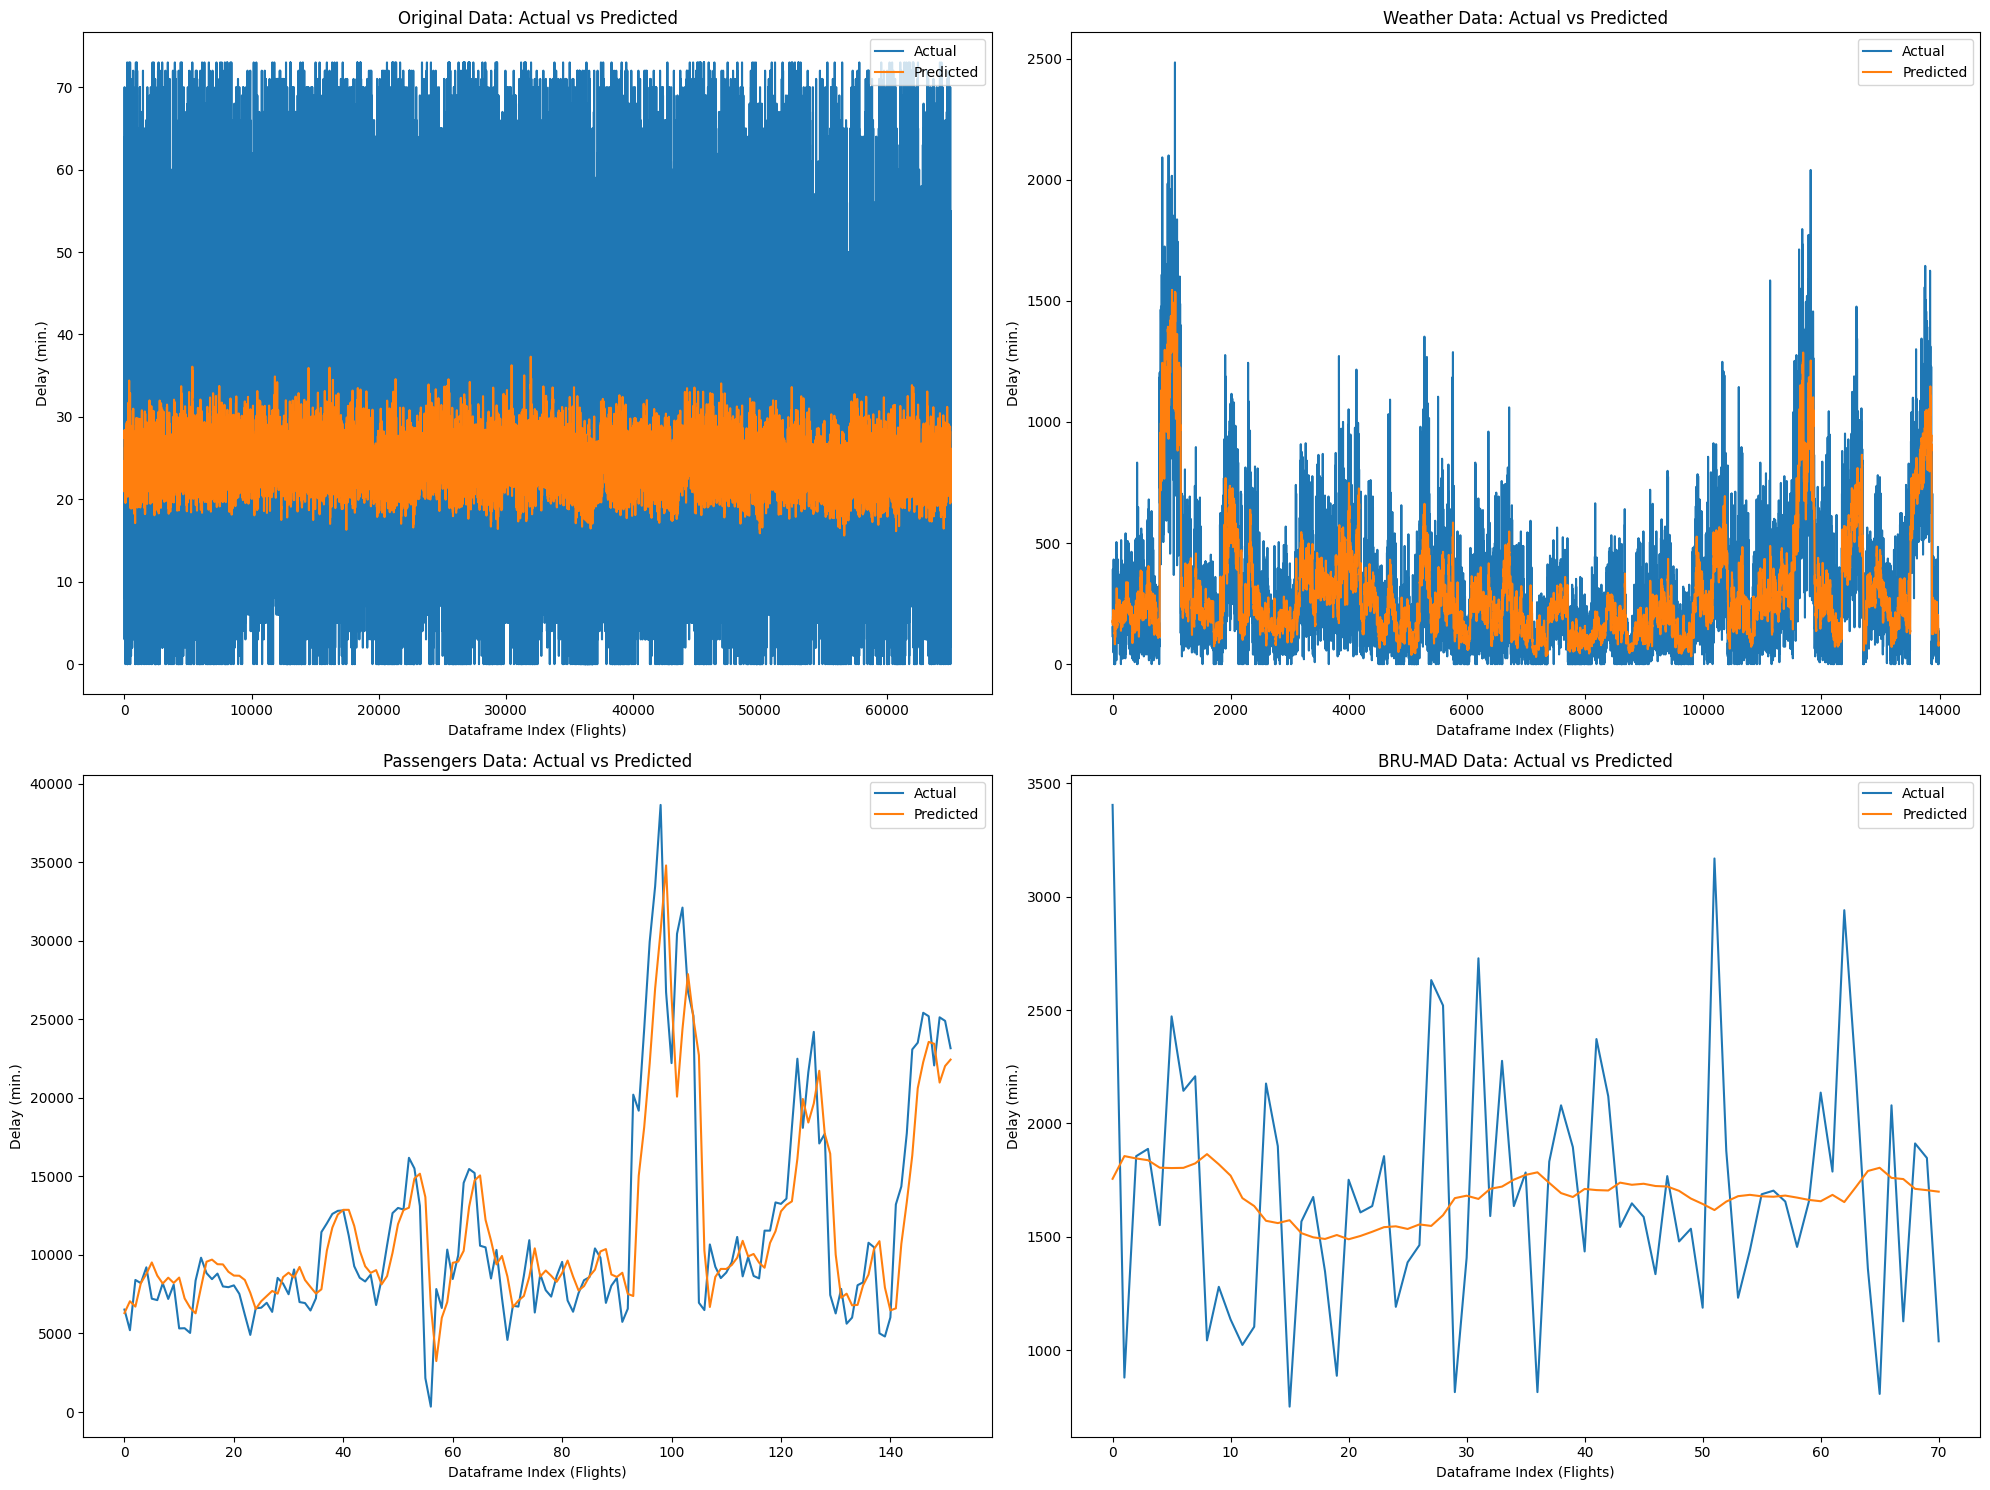

In [4]:
nn_evaluation = []
shap_results = []
dataframes = [
    (df_filtered_original, 'dep_delay'),
    (df_filtered_weather, 'total_dep_delay'),
    (df_filtered_passengers, 'total_dep_delay'),
    (df_filtered_BRU_MAD, 'total_dep_delay'),
]
titles = ["Original Data", "Weather Data", "Passengers Data", "BRU-MAD Data"]

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, ((df, column), title) in enumerate(zip(dataframes, titles)):
    print(f"Current Dataset: {title}")
    nn = NeuralNetworks(df, column)
    nn_model, nn_actual, nn_predictions, nn_metrics = nn.neural_networks(title)
    nn_evaluation.append(nn_metrics)
    nn_plots(axes, i, nn_actual, nn_predictions, title)
    # shap_results.append((nn_model, x_test, title))
    
plt.tight_layout()
plt.show()

# Generate SHAP explanations
# for nn_model, x_test, title in shap_results:  # Fix: Store x_test instead of nn_actual
    # print(f"Generating SHAP explanations for: {title}")
    # NeuralNetworks.explain_lstm(nn_model, x_test)  # Fix: Pass x_test instead of nn_actual

In [5]:
nn_summary_df = pd.DataFrame(nn_evaluation)
nn_summary_df

,Dataset,Model Type,Look Back Period,Final Validation Loss,MAE (min.),MAPE (%),RMSE (min.),Total Training Epochs
0,Original Data,LSTM,10,0.044519,12.00,78.05,15.34,9
1,Weather Data,LSTM,10,0.002624,124.76,95.74,171.23,13
2,Passengers Data,LSTM,10,0.004667,2342.00,36.74,3501.29,49
3,BRU-MAD Data,LSTM,10,0.040634,420.03,28.52,558.42,12


### **2. Statistical Time-Series Models**

#### **2.1. ARIMA**

ARIMA (AutoRegressive Integrated Moving Average) is a statistical model suited for time series data. If the dataset has time-related features (like delays or flight frequencies over time), ARIMA can be used to predict future values.

* **Prepare Time Series Data**: Ensure the data is sorted by time. Create a dataset with a single time-dependent feature (e.g., delays, flight counts).
* **Build ARIMA Model**: Fit the model by using statsmodels.
    * p = AutoRegressive part (AR, **Auto Regressive** timeseries forecasting model)
    * d = Differencing (I, **Integrated**)
    * q = Moving Average part (MA, **Moving Average**)


**Regression**. We are trying to predict something based on other things. 

**Auto Regression**. We are trying to predict something based on its past values. There could be some pattern in our historical data, and if we can capture that pattern, we can get a much stronger prediction.
* Data we are trying to predict.
    * $f_t$ = Quantity of delayed flights this month.
* Data available to predict $f_t$ with => **Lags**.
    * $f_{t-1}$ = Quantity of delayed flights last month.
    * $f_{t-12}$ = Quantity of delayed flights 12 months ago.

The model should not include every single lag (from 1 to 12) because it will get a lot of statistical issues such as overfitting. That's why we need to figure out which lags are important. How? **PACF chart** (Partial Auto Correlation Function). The model should only include the lags whose direct effects are high either positive or negative. If they are 0 or close to 0, they should not be included. Because they don't have a direct correlation with delays.

e.g. $f_{t-3}$ => direct effect on $f_{t}$ and this means it removes the effect of $f_{t-1}$ and $f_{t-2}$ the delays 1 and 2 months ago.

* $avgf_t$ = Average delayed flights this month.
* $avgf_{t-1}$ = Average delayed flights 1 month ago.
* $avgf_{t-2}$ = Average delayed flights 2 months ago.

* **ACF chart (Auto Correlation Function)**: Takes into account both the direct and indirect effects. With ACF might seem like a good predictor since the pearson correlation is high. But it might be high because of the indirect effects and therefore the direct effect has little to no correlation.
    * E.g. corr($avgf_{t-2}$, $avgf_t$) 
        * Direct: $avgf_{t-2}$ => $avgf_t$
        * Indirect: $avgf_{t-2}$ => $avgf_{t-1}$ => $avgf_t$


* **PACF chart (Partial Auto Correlation Function)**: Only takes into account the direct effect. Why? To see whether the delayed flights on $avgf_{t-2}$ is a good predictor of $avgf_t$. 

**Integrated**: Used to remove trends and make the data stationary. Instead of predicting the **time series** itself, the model predicts **differences of the time series**, from one timestamp to the previous timestamp. This is done by creating a time series **$z_t = a_{t+1} - a_t$** which takes the number of delayed flights in one month - the number of delayed flights from the previous month.

**Moving Average**: **$\hat{f_t} = u + o_1 e_{t-1}$** => Predicted number of flights ($\hat{f_t}$) = mean (u) + coefficient ($o_1$) * the error from the previous month ($e_t$).
* u = constant (every month we have the same amount of delayed flights)
* $f_t$ = changes (how many delayed flights we should have had that month)
* $o_1$ = some coefficient (such as 0.5)
* $e_t(u_e, o_e)$ = the error (the wrong amount delayed flights (mean of the error, standard deviation of the error))

e.g. 10($\hat{f_t}$) -2($e_t$) = 8($f_t$) => 10 + (-2($e_t$) / 2($o_1$)) = 9($\hat{f_t}$) +1($e_t$) = 10($f_t$) => etc.

The model is explaining that we will always have the same amount of delayed flights, but we will adjust that by 50% (coefficient) of whatever the error was last month. We are taking information about how wrong we were in the previous time period (t) to make a better estimate for the current time period (t - 1). We have our average (10), which it's moving around, but it's always centered at the average.

##### **2.1.1. Choosing d (Differencing)**

It's used to make the time series stationary by for example, removing trends and seasonality. 
* Check stationarity with a Dickey-Fuller test. 
    * If the p-value is less than 0.05, the data is likely stationary. (d = 0)
    * If the test result indicates non-stationarity, apply differencing. (d = 1) or (d = 2)
* Determine d:
    * First trying d = 1 (first difference), which is common for time series with a trend.
    * If the data still shows a trend, try d = 2 (second difference), though higher differencing values are rare.

In [3]:
train_end = datetime(2023, 6, 30)
test_end = datetime(2023, 12, 31)
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)

df_arima = df_BRU_MAD_daily[['Date', 'total_dep_delay']].copy()
df_arima['Date'] = pd.to_datetime(df_arima['Date'])
df_arima = df_arima.sort_values(by='Date')
time_series_summary = []

time_series_analysis = TimeSeriesAnalysis(df_arima, start_date, end_date, train_end, test_end, column='total_dep_delay')
differenced_data, is_stationary = time_series_analysis.check_stationarity()

if is_stationary:
    print("The data is stationary and ready for modeling.")
else:
    print("The data is still non-stationary after differencing.")

- ADF Test p-value (original): 0.0002712540180082813
Series is stationary after 0 differencing -> d = 0.
The data is stationary and ready for modeling.


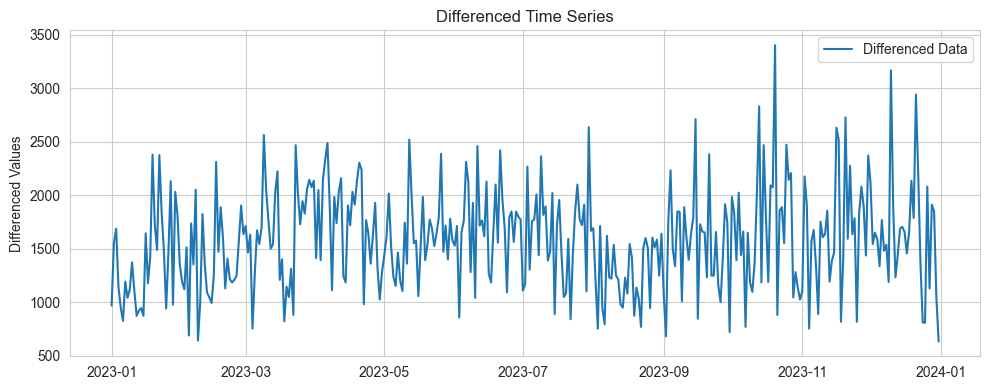

In [4]:
plt.figure(figsize=(10, 4))
plt.plot(differenced_data, label='Differenced Data')
plt.title("Differenced Time Series")
plt.ylabel("Differenced Values")
plt.legend()
plt.tight_layout()
plt.show()


##### **2.1.2. Choosing p (AR Order) and q (MA Order)**

The best practice is to start with a small p and q, and gradually increase them.

**Autoregressive (AR) order (p).**
* AR it's the relationship between the current observation and previous observations.
* This can be determined by analyzing the Partial Autocorrelation Function (PACF) plot.
    * If the PACF plot cuts off at some lag, this could be an estimation for p. (p = cutoff lag at PACF)

**Moving Average (MA) order (q).**
* MA  it's the relationship between the current observation and the residual errors from previous time steps.
* This can be determined by analyzing the Autocorrelation Function (ACF) plot.
    * If the ACF plot cuts off at a certain lag, it suggests that lag as the possible q. (q = cutoff lag at ACF)

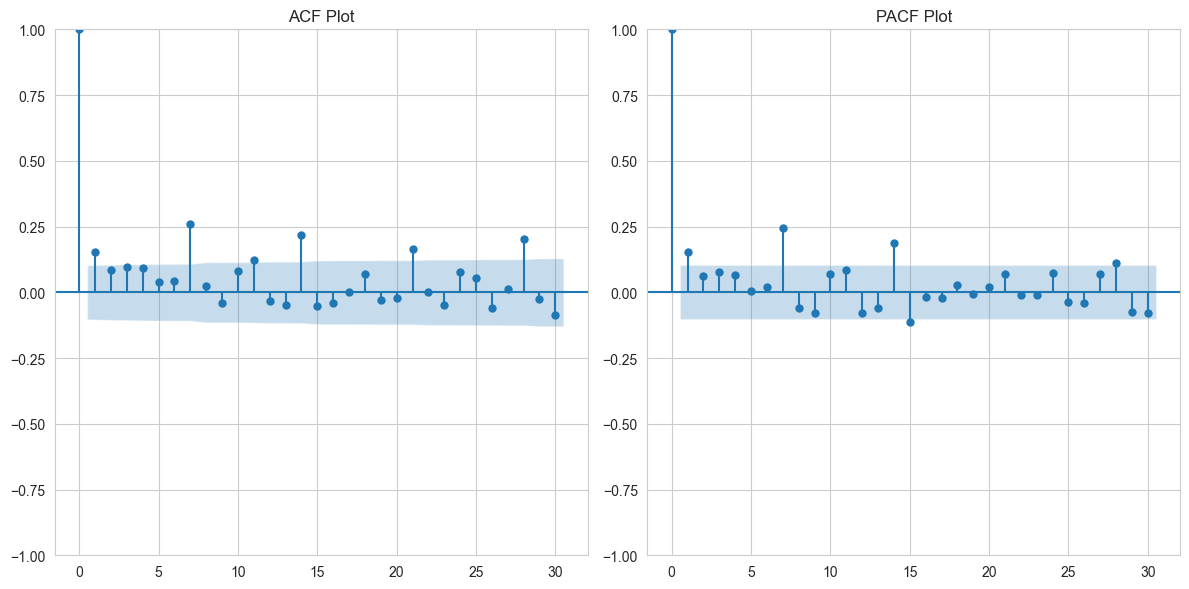

In [5]:
time_series_analysis.plot_acf_pacf(30, 30) # pacf lags need to be less than half of the total observations (12) 11, 5
plt.show()

ACF Plot: This plot shows the correlation between the series and its lags.
* The cutoff point indicates the value for q, the order of the MA term (Moving Average). Where the autocorrelation becomes negligible (near zero). 
* If the ACF decays slowly, this suggests a higher order for q. If it cuts off sharply after a few lags, suggests a lower order for q.

PACF Plot: This plot shows the partial correlation of the series with its lags, controlling for the effect of earlier lags.
* Look for the cutoff point in the PACF plot. The lag where the PACF cuts off suggests the AR order (p).
* If the PACF cuts off after lag k, this suggests that p = k (i.e., the AR model only needs k previous values).
* If the PACF decays gradually, you may need a higher order for p.

##### **2.1.3. Fitting the ARIMA Model**

* d=0, it means no differencing has been applied to the data, and therefore the original data is considered stationary. 
* Even if the data is stationary based on the ADF test, some residual trend could still cause problems for the AR and MA parameter estimation when d=0.

                               SARIMAX Results                                
Dep. Variable:        total_dep_delay   No. Observations:                  181
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1346.052
Date:                Fri, 14 Feb 2025   AIC                           2704.104
Time:                        13:41:46   BIC                           2723.295
Sample:                    01-01-2023   HQIC                          2711.884
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1583.5356     57.060     27.752      0.000    1471.700    1695.371
ar.L1         -0.0014     92.519  -1.56e-05      1.000    -181.336     181.333
ar.L2          0.5685     69.758      0.008      0.9

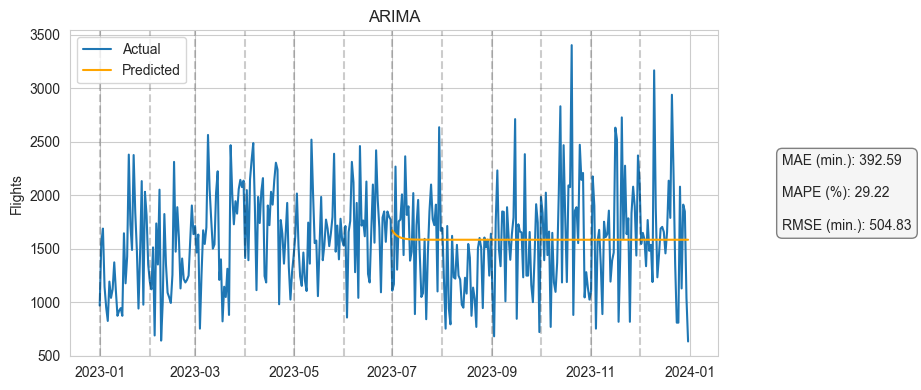

In [6]:
arima_model, arima_test_data, arima_predictions, arima_residuals, arima_metrics = time_series_analysis.arima_sarimax_forecast(order=(2, 0, 2)) #3, 1, 3 or 2, 1, 3
time_series_summary.append({"Model": "ARIMA", **arima_metrics}) # Store results

**Warning [2]. Covariance matrix is singular or near-singular.**
* Some parameters might be highly correlated.
* The model may have overfitting.
* The dataset doesn't have enough observations to support the model's complexity.

**our_model.mle_retvals** provides detailed information about the **Maximum Likelihood Estimation (MLE)** process for ARIMA.
* fopt: The optimized objective function value. This value looks **reasonable** and suggests that the model minimized the likelihood function **successfully**.
* gopt: The gradient of the objective function at the solution. The values are **close to zero**, indicating a **good fit** at the optimization's end.
* fcalls: The number of function calls made. A high number, combined with a failure to converge, indicates **the optimizer struggled to find a solution**.
* warnflag: A warning flag indicating the status of the optimization:
    * **0: Convergence was successful.**
    * 1: Maximum iterations were exceeded.
    * 2: Other issues prevented convergence.
* converged: A boolean flag indicating whether the optimization converged. True confirms that **convergence was achieved**.
* iterations: The number of iterations performed by the optimizer. The optimizer stopped because it found a solution (111) before reaching the maxiter limit (500).

#### **2.2. SARIMAX**
SARIMAX (Seasonal AutoRegressive Integrated Moving Average with Exogenous Regressors) models seasonality in time series data. A "seasonal cycle" refers to a full repetition of a pattern in your time series data. The S ((P, D, Q, S)) is the seasonal period or "Seasonal Order".

SARIMAX is more suitable for datasets with additional features compared to ARIMA. It can include exogenous variables (X) to improve predictions.

It needs at least two full seasonal cycles. If there is not enough past data covering multiple seasonal cycles, the model cannot learn the pattern properly. This leads to warnings like: UserWarning: Too few observations to estimate starting parameters for seasonal ARIMA.

E.g. If the dataset follows a yearly pattern...
- One seasonal cycle = 12 months            => S = 12. 
- Two full cycles = 24 months (2 years)     => At least 2 × S observations. 



                                     SARIMAX Results                                      
Dep. Variable:                    total_dep_delay   No. Observations:                  181
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 30)   Log Likelihood               -1156.636
Date:                            Fri, 14 Feb 2025   AIC                           2323.272
Time:                                    13:41:52   BIC                           2338.358
Sample:                                01-01-2023   HQIC                          2329.400
                                     - 06-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6211      0.214      2.900      0.004       0.201       1.041
ma.L1         -0.3474      0.257   

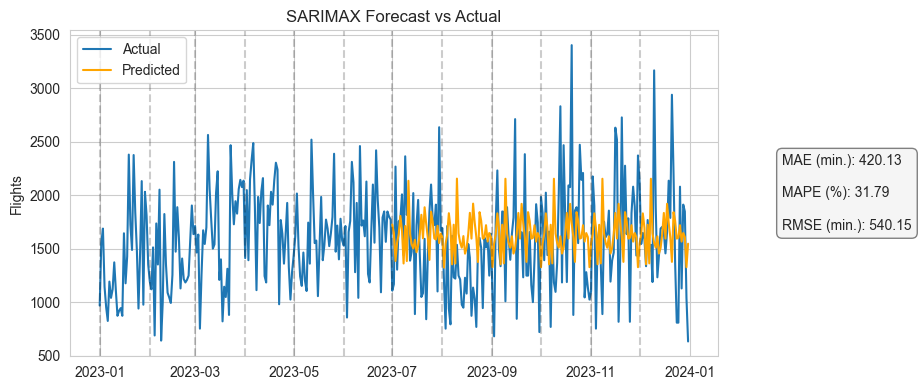

In [7]:
#sarimax_analysis = TimeSeriesAnalysis(df_BRU_MAD_daily, start_date, end_date, train_end, test_end, column='total_dep_delay')
sarimax_model, sarimax_test_data, sarimax_predictions, sarimax_residuals, sarimax_metrics = time_series_analysis.arima_sarimax_forecast(order=(1, 0, 1), seasonal_order=(1, 1, 1, 30))
time_series_summary.append({"Model": "SARIMAX", **sarimax_metrics})

#### **2.3. Rolling Forecast Origin**
Instead of trying to predict 30 or more days right away, it predicts just one, and then it takes into account its real value, and then it predicts the nest one, and so on.

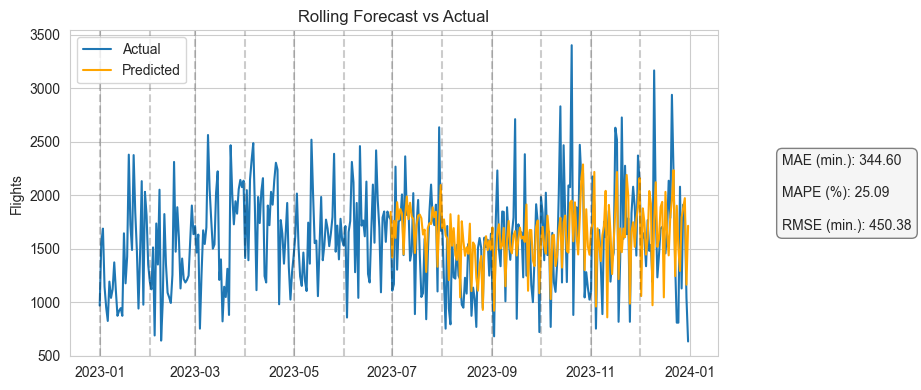

In [8]:
rolling_actual, rolling_predictions, rolling_residuals, rolling_metrics = time_series_analysis.rolling_forecast(order=(1, 1, 1), train_window=180, seasonal_order=(0, 1, 1, 7))
time_series_summary.append({"Model": "Rolling Forecast", **rolling_metrics})

#### **2.4. Prophet**

Prophet data range: 2023-01-01 00:00:00 - 2023-12-31 00:00:00
Train data range: 2023-01-01 00:00:00 - 2023-06-30 00:00:00 (181 rows)
Test data range: 2023-07-01 00:00:00 - 2023-12-31 00:00:00 (184 rows)


13:43:11 - cmdstanpy - INFO - Chain [1] start processing
13:43:11 - cmdstanpy - INFO - Chain [1] done processing


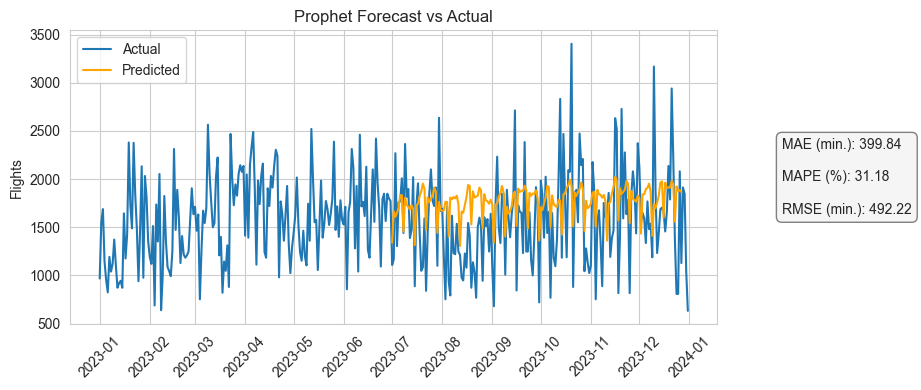

In [9]:
prophet_predictions, prophet_residuals, prophet_metrics = time_series_analysis.prophet_forecast(periods=180, frequency='D')
time_series_summary.append({"Model": "Prophet", **prophet_metrics})

### **4. Model Comparisons**

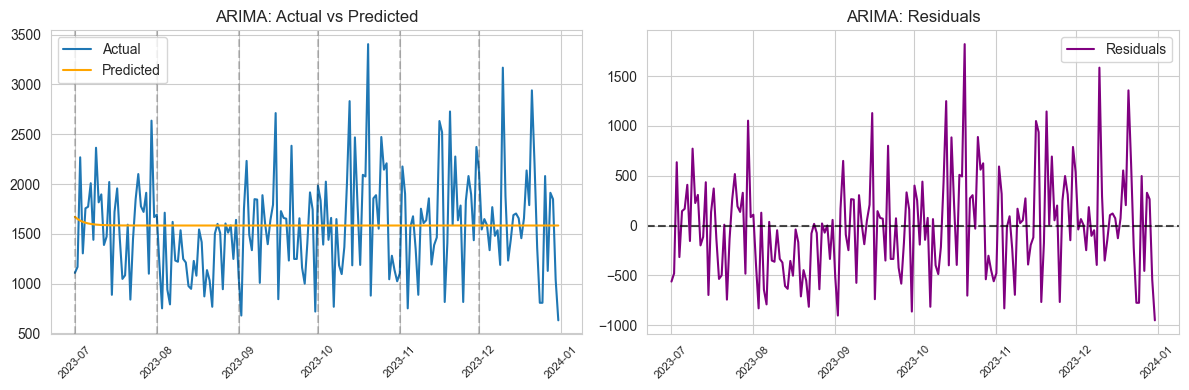

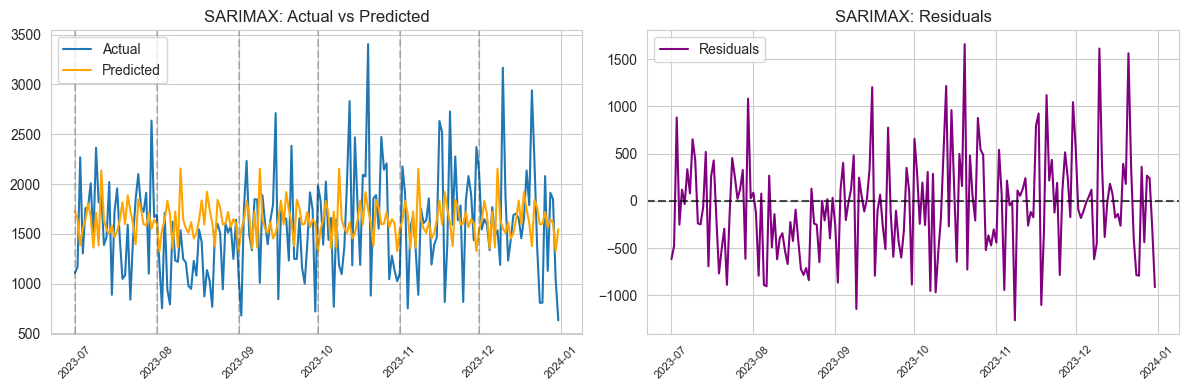

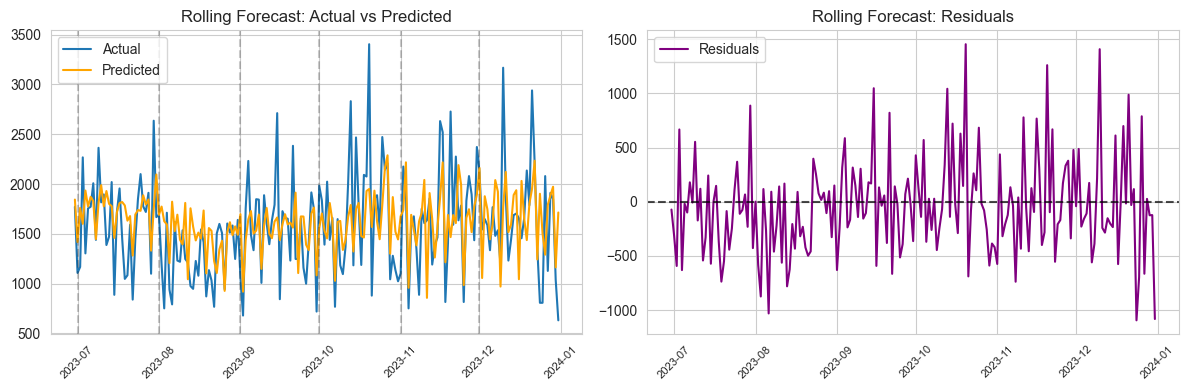

In [10]:
time_series_analysis.plot_combined("ARIMA", arima_predictions, arima_residuals)
time_series_analysis.plot_combined("SARIMAX", sarimax_predictions, sarimax_residuals)
time_series_analysis.plot_combined("Rolling Forecast", rolling_predictions, rolling_residuals)

# Combine Results into a DataFrame
time_series_evaluation_df = pd.DataFrame(time_series_summary)

In [11]:
time_series_evaluation_df

,Model,MAE (min.),MAPE (%),RMSE (min.)
0,ARIMA,392.59,29.22,504.83
1,SARIMAX,420.13,31.79,540.15
2,Rolling Forecast,344.60,25.09,450.38
3,Prophet,399.84,31.18,492.22


* MAE gives the average error in absolute terms, without considering whether the prediction is too high or too low.
* RMSE penalizes larger errors more than smaller ones due to squaring the errors, making it sensitive to outliers.
* MAPE represents the average percentage error relative to the actual values. Lower MAPE means the model is making smaller relative errors.

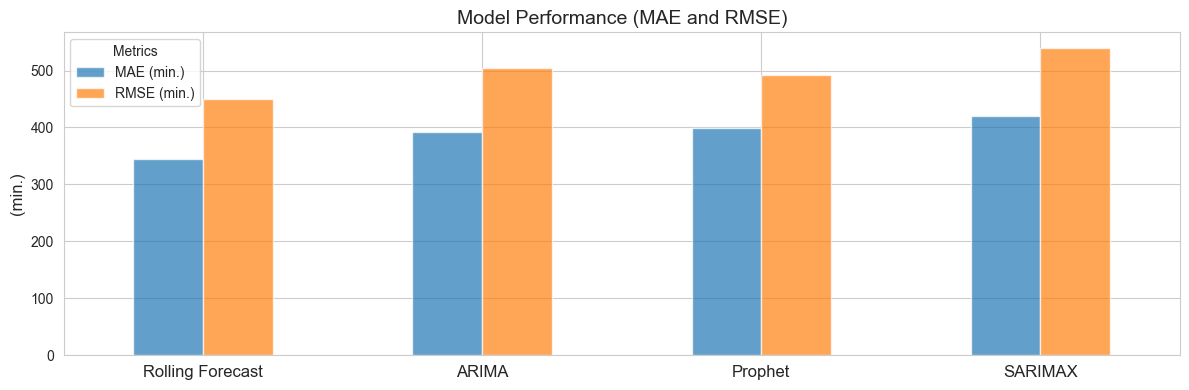

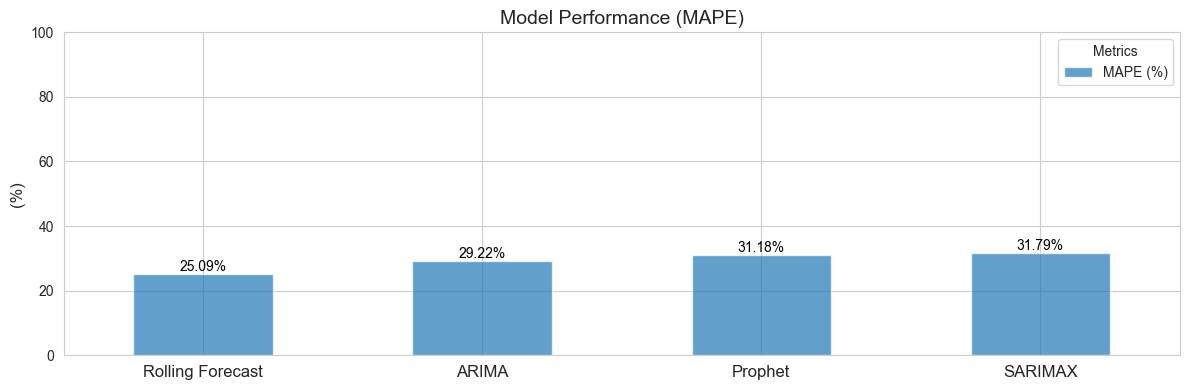

In [49]:
# Plot model performance (metrics)
plot_metrics(time_series_summary)

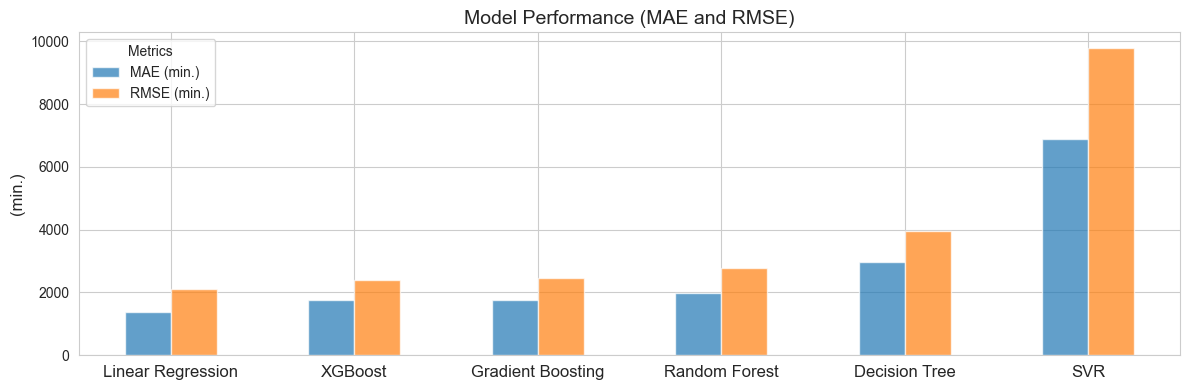

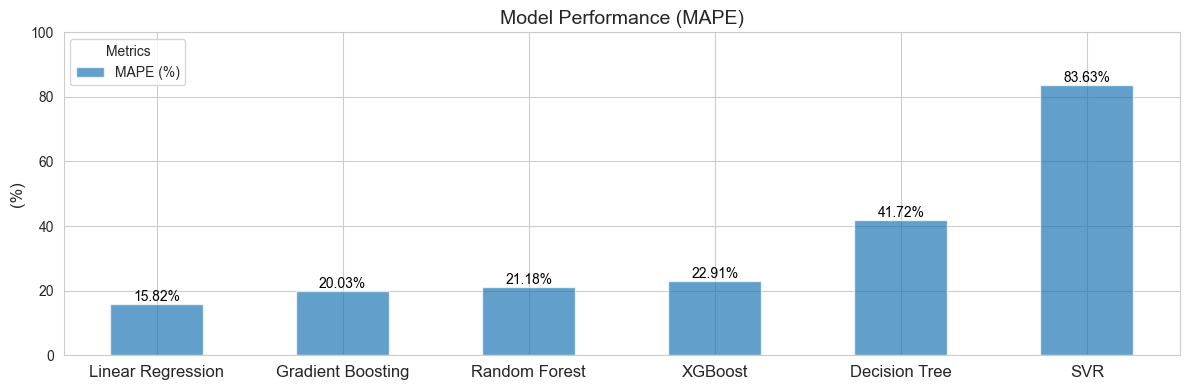

In [50]:
ml_metrics = model_summary_passengers_df.to_dict(orient="records")
plot_metrics(ml_metrics)

Predictions for all the routes (using weather data)
* Linear Regression
* Decision Tree
* Random Forest
* Support Vector Regression (SVR)
* Gradient Boosting Machines (GBM)
* XGBoost

Predictions for all the routes (without passenger data)
* Long Short-Term Memory (LSTM)
* Recurrent Neural Networks (RNNs)

Predictions in 1 route (BRU-MAD)
* ARIMA
* SARIMAX
* Rolling Forecast
* Prophet


Answer question: why these models and what learns faster

### **5. Residual Analysis**
* **Calculate residuals**: The differences between the actual and predicted values.
* **Linearity**: They should show no clear pattern when plotted against fitted values.
* **Normality**: They should follow a normal distribution (with Q-Q plot or histogram).
* **Autocorrelation**: They should not show autocorrelation (check with Durbin-Watson or ACF).
* **Homoscedasticity**: They should have constant variance (no funnel shapes).

In [ ]:
"""plt.figure(figsize=(12, 8))  

# Linear Regression - Residual Analysis
linear_res_plot = ResidualAnalysis()
linear_res_plot.plot_residuals("Linear Regression", subplot_position=(2, 2, 1))

# Random Forest - Residual Analysis
random_res_plot = ResidualAnalysis()
random_res_plot.plot_residuals("Random Forest", subplot_position=(2, 2, 2))

plt.tight_layout()
plt.show()"""

In [ ]:
"""plt.figure(figsize=(12, 6))

linear_res_plot.q_q_normality("Linear Regression", subplot_position=(1, 2, 1))
random_res_plot.q_q_normality("Random Forest", subplot_position=(1, 2, 2))

plt.tight_layout()
plt.ylim(-2000, 4000)
plt.show()"""

In [ ]:
"""plt.figure(figsize=(12, 6))

linear_res_plot.histogram_normality("Linear Regression", subplot_position=(1, 2, 1))
random_res_plot.histogram_normality("Random Forest", subplot_position=(1, 2, 2))

plt.tight_layout()
plt.xlim(-2000, 4000) 
plt.show()"""